### 노동자 성별 예측- 노동자들의 데이터를 보고 성별을 예측하자

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline

#warning messages
import warnings
warnings.filterwarnings('ignore')

#scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

#시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### 그래프 한글 깨짐 해결
import platform
platform.system()
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) #마이너스폰트 설정
#plt.rc('font', family='AppleGothic') - Darwin : Mac  

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import GridSearchCV # 최적의 파라미터 검색

from sklearn.model_selection import cross_val_score

In [2]:
#데이터 불러오기
train = pd.read_csv('human.csv', encoding='cp949').set_index('아이디')
test = pd.read_csv('human_new.csv', encoding='cp949').set_index('아이디')
train.head()

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,성별,자본 이득,자본 손실,주당 시간,모국
아이디,,,,,,,,,,,,,,
H20001,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
H20002,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
H20003,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
H20004,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
H20005,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [3]:
#원본 복사
mdf = train.copy()

In [4]:
mdf.isnull().sum()

나이           0
노동 계급     1836
fnlwgt       0
학력           0
교육 수         0
혼인 상태        0
직업        1843
관계           0
인종           0
성별           0
자본 이득        0
자본 손실        0
주당 시간        0
모국         583
dtype: int64

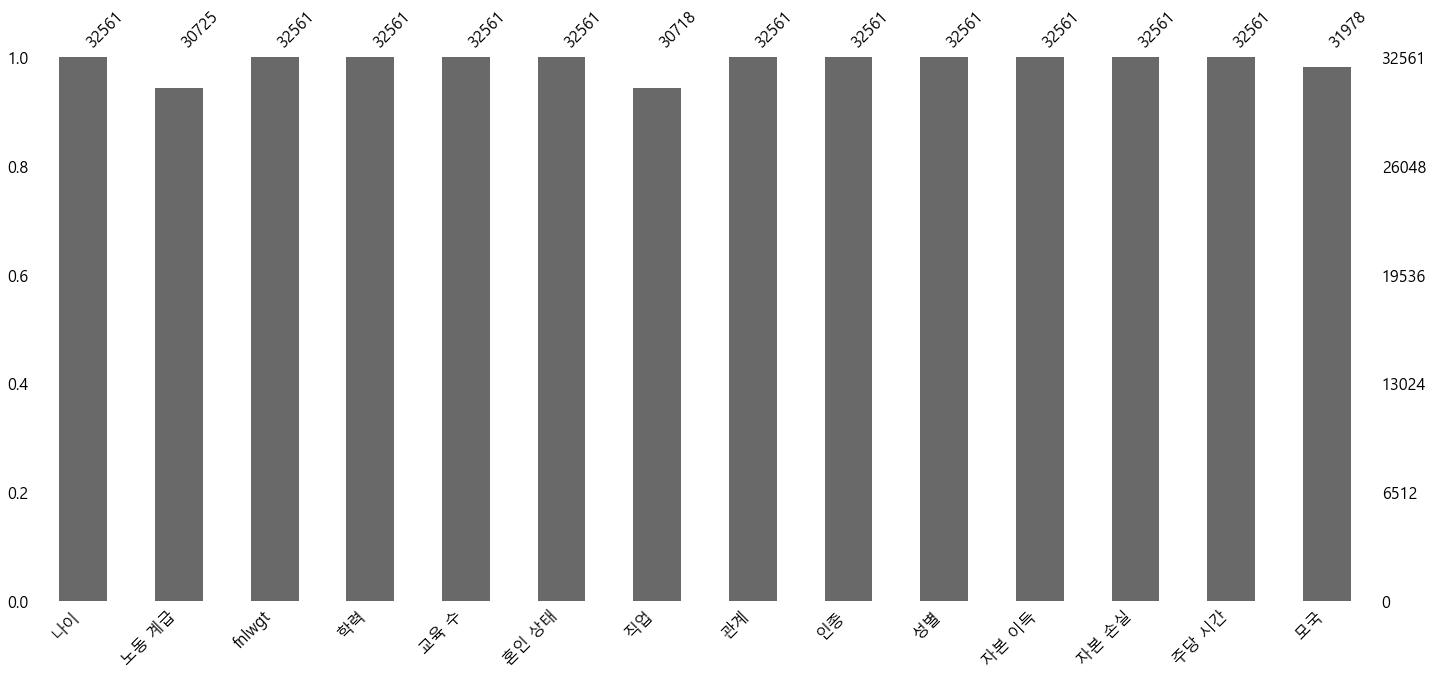

In [5]:
#pip install missingno 설치 -> 결측치 시각화
import missingno as msno
import matplotlib as mpl
#msno.matrix(mdf)
msno.bar(mdf)
plt.show()

In [6]:
#결측값 최빈값 대체 처리 
from sklearn.impute import SimpleImputer
imputer_nul = SimpleImputer(strategy="most_frequent")
nul =['노동 계급','직업','모국']
mdf[nul]=imputer_nul.fit_transform(mdf[nul])

In [7]:
# 결혼 변수 추가
mdf['혼인 상태'] = mdf['혼인 상태'].str.lstrip()
mdf['혼인 상태'].value_counts()   

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: 혼인 상태, dtype: int64

In [8]:
str1 = 'Never-married','Divorced'
def marr(x):
    결혼 = ''
    if x in str1: 결혼 = '무'
    else: 결혼 = '유'
    return 결혼

In [9]:
mdf['결혼'] = mdf['혼인 상태'].apply(lambda x : marr(x))

In [10]:
#배우자 변수 
spo1 = 'Married-AF-spouse'
spo2 = 'Never-married', 'Divorced', 'Separated', 'Widowed'
def spouse(s):
    배우자=''
    if s in spo1 : 배우자 = '군인'
    elif s in spo2 :  배우자 = '무'
    else: 배우자 = '일반'
    return 배우자

In [11]:
mdf['배우자'] =mdf['혼인 상태'].apply(lambda s: spouse(s))

<AxesSubplot:xlabel='성별', ylabel='나이'>

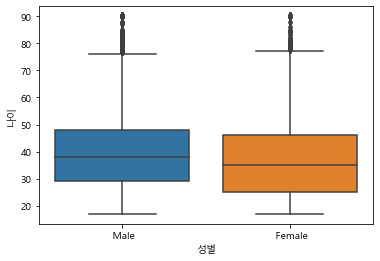

In [12]:
sns.boxplot(x="성별", y= "나이", data=mdf)

In [13]:
mdf['나이'].count()

32561

In [14]:
#나이 이상치 제거 outliers = mdf['나이'], mdf['주당 시간']
q1 = mdf['나이'].quantile(0.25)
q3 = mdf['나이'].quantile(0.75)
IQR = q3 - q1
old = mdf[(mdf['나이'] < (q1 - 1.5 * IQR)) | (mdf['나이'] > (q3 + 1.5 * IQR))]
#old

In [15]:
# IQR 기준 이상치 행 지우기
mdf = mdf.drop(old.index, axis=0)
mdf.shape

(32418, 16)

<AxesSubplot:xlabel='성별', ylabel='주당 시간'>

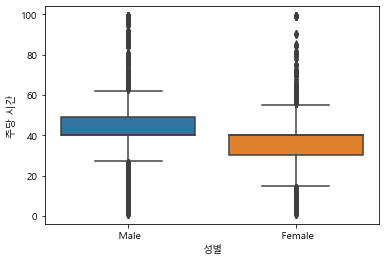

In [16]:
sns.boxplot(x="성별", y= "주당 시간", data=mdf)

In [17]:
df_jobs = pd.get_dummies(mdf['직업'])

In [18]:
mdf = pd.concat([mdf,df_jobs], axis=1)

In [19]:
mdf = mdf.drop(['직업','자본 이득','자본 손실','fnlwgt','인종'], axis=1)

In [20]:
mdf.head()

,나이,노동 계급,학력,교육 수,혼인 상태,관계,성별,주당 시간,모국,결혼,...,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
아이디,,,,,,,,,,,,,,,,,,,,,
H20001,39,State-gov,Bachelors,13,Never-married,Not-in-family,Male,40,United-States,무,...,0,0,0,0,0,0,0,0,0,0
H20002,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Husband,Male,13,United-States,유,...,0,0,0,0,0,0,0,0,0,0
H20003,38,Private,HS-grad,9,Divorced,Not-in-family,Male,40,United-States,무,...,0,1,0,0,0,0,0,0,0,0
H20004,53,Private,11th,7,Married-civ-spouse,Husband,Male,40,United-States,유,...,0,1,0,0,0,0,0,0,0,0
H20005,28,Private,Bachelors,13,Married-civ-spouse,Wife,Female,40,Cuba,유,...,0,0,0,0,0,1,0,0,0,0


In [21]:
#object, num 구분
obj = mdf.dtypes[mdf.dtypes == 'object'].index
num = mdf.dtypes[mdf.dtypes != 'object'].index
display(obj)
display(num)

Index(['노동 계급', '학력', '혼인 상태', '관계', '성별', '모국', '결혼', '배우자'], dtype='object')

Index(['나이', '교육 수', '주당 시간', ' Adm-clerical', ' Armed-Forces',
       ' Craft-repair', ' Exec-managerial', ' Farming-fishing',
       ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service',
       ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales',
       ' Tech-support', ' Transport-moving'],
      dtype='object')

In [22]:
mdf[obj] = mdf[obj].apply(lambda x: x.astype('category').cat.codes)

<AxesSubplot:>

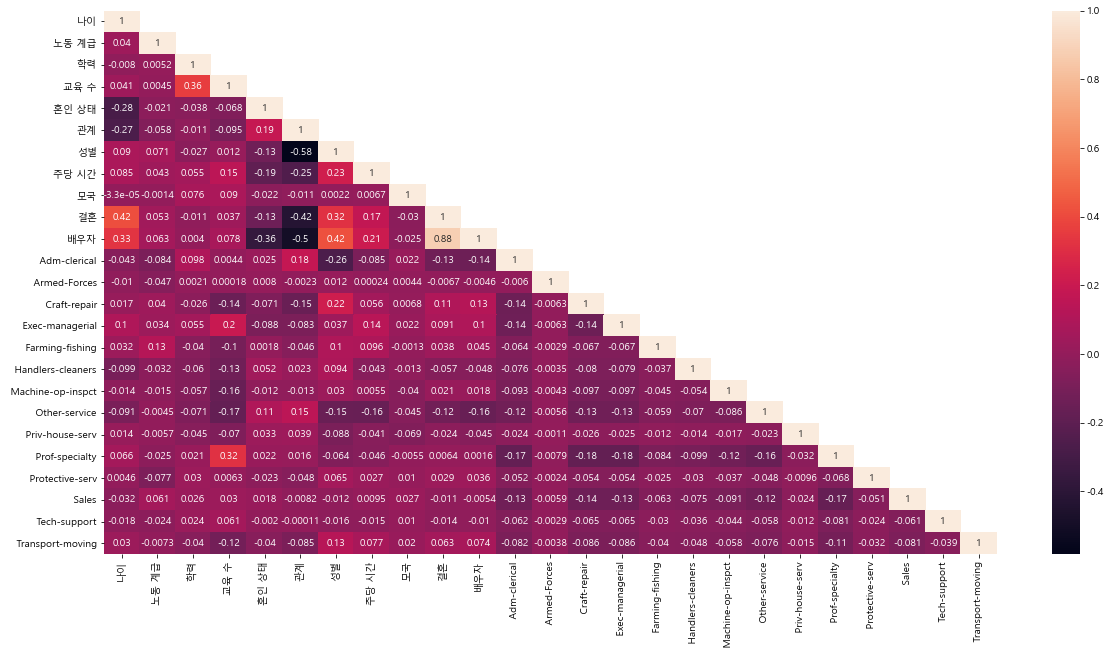

In [23]:
## 성별과 각 컬럼 간의 연관성 확인?
corr=mdf.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr, mask=mask, vmax=1.,annot=True)

## 참고 사이트
# https://www.kaggle.com/fkstepz/step-by-step-predict-bike-sharing-demand

In [24]:
mdf.describe().T

,count,mean,std,min,25%,50%,75%,max
나이,32418.0,38.381609,13.329881,17.0,28.0,37.0,47.0,78.0
노동 계급,32418.0,3.093713,1.107361,0.0,3.0,3.0,3.0,7.0
학력,32418.0,10.301499,3.869988,0.0,9.0,11.0,12.0,15.0
교육 수,32418.0,10.083164,2.567867,1.0,9.0,10.0,12.0,16.0
혼인 상태,32418.0,2.607872,1.503051,0.0,2.0,2.0,4.0,6.0
관계,32418.0,1.448208,1.607559,0.0,0.0,1.0,3.0,5.0
성별,32418.0,0.669073,0.470554,0.0,0.0,1.0,1.0,1.0
주당 시간,32418.0,40.491332,12.296677,1.0,40.0,40.0,45.0,99.0
모국,32418.0,36.417608,6.054274,0.0,38.0,38.0,38.0,40.0
결혼,32418.0,0.534209,0.498836,0.0,0.0,1.0,1.0,1.0


<AxesSubplot:xlabel='성별', ylabel='결혼'>

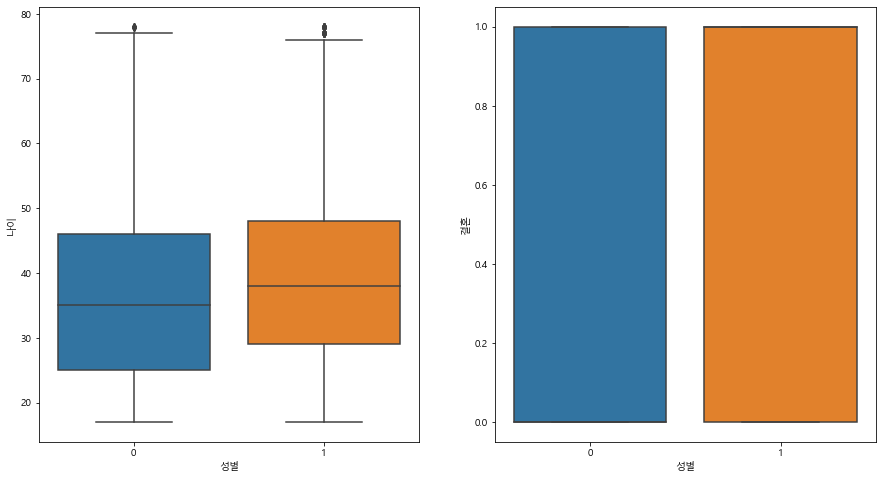

In [25]:
## 연관성 & 이상치 확인 가능
f, axes = plt.subplots(ncols=2, figsize=(15,8))
sns.boxplot(x="성별", y= "나이", data=mdf, ax=axes[0])
sns.boxplot(x="성별", y= "결혼", data=mdf, ax=axes[1])
#plt.show()

In [26]:
mdf.shape

(32418, 25)

In [27]:
mdf.head()

,나이,노동 계급,학력,교육 수,혼인 상태,관계,성별,주당 시간,모국,결혼,...,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
아이디,,,,,,,,,,,,,,,,,,,,,
H20001,39,6,9,13,4,1,1,40,38,0,...,0,0,0,0,0,0,0,0,0,0
H20002,50,5,9,13,2,0,1,13,38,1,...,0,0,0,0,0,0,0,0,0,0
H20003,38,3,11,9,0,1,1,40,38,0,...,0,1,0,0,0,0,0,0,0,0
H20004,53,3,1,7,2,0,1,40,38,1,...,0,1,0,0,0,0,0,0,0,0
H20005,28,3,9,13,2,5,0,40,4,1,...,0,0,0,0,0,1,0,0,0,0


In [28]:
from sklearn.model_selection import train_test_split  
X = mdf.drop(['성별'], axis=1) 
Y = mdf['성별']                    
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

###########################################################################################

In [29]:
#XGB model
import xgboost as xgb
from xgboost import XGBClassifier

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

params = {'max_depth':4,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stoppings':100
         }
num_rounds = 200

In [30]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'),(dtest, 'eval')]
# 하이퍼 파라미터와 early stoppinig 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[16:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.64244	eval-logloss:0.64263
[1]	train-logloss:0.60071	eval-logloss:0.60125
[2]	train-logloss:0.56593	eval-logloss:0.56652
[3]	train-logloss:0.53647	eval-logloss:0.53720
[4]	train-logloss:0.51110	eval-logloss:0.51228
[5]	train-logloss:0.48921	eval-logloss:0.49056
[6]	train-logloss:0.47022	eval-logloss:0.47171
[7]	train-logloss:0.45347	eval-logloss:0.45530
[8]	train-logloss:0.43879	eval-logloss:0.44091
[9]	train-logloss:0.42585	eval-logloss:0.42784
[10]	train-logloss:0.41406	eval-logloss:0.41638
[11]	train-logloss:0.40361	eval-logloss:0.40616
[12]	train-logloss:0.39403	eval-logloss:0

[162]	train-logloss:0.27749	eval-logloss:0.29569
[163]	train-logloss:0.27733	eval-logloss:0.29563
[164]	train-logloss:0.27731	eval-logloss:0.29562
[165]	train-logloss:0.27720	eval-logloss:0.29560
[166]	train-logloss:0.27709	eval-logloss:0.29560
[167]	train-logloss:0.27689	eval-logloss:0.29548
[168]	train-logloss:0.27672	eval-logloss:0.29547
[169]	train-logloss:0.27666	eval-logloss:0.29551
[170]	train-logloss:0.27658	eval-logloss:0.29550
[171]	train-logloss:0.27650	eval-logloss:0.29549
[172]	train-logloss:0.27644	eval-logloss:0.29551
[173]	train-logloss:0.27641	eval-logloss:0.29549
[174]	train-logloss:0.27637	eval-logloss:0.29550
[175]	train-logloss:0.27628	eval-logloss:0.29554
[176]	train-logloss:0.27614	eval-logloss:0.29552
[177]	train-logloss:0.27610	eval-logloss:0.29553
[178]	train-logloss:0.27606	eval-logloss:0.29553
[179]	train-logloss:0.27586	eval-logloss:0.29548
[180]	train-logloss:0.27584	eval-logloss:0.29547
[181]	train-logloss:0.27567	eval-logloss:0.29544
[182]	train-logloss:

In [31]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]


predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨
[1.    1.    1.    1.    0.552 1.    1.    1.    1.    0.527]


In [32]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [33]:
get_clf_eval(y_test, preds)

오차행렬
[[2117  568]
 [ 729 4691]]
정확도: 0.8400, 정밀도: 0.8920, 재현율: 0.8655


############################# 데이터 불균형 

In [34]:
#성별 불균형 확인
mdf['성별'].value_counts()

1    21690
0    10728
Name: 성별, dtype: int64

In [35]:
'''
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())
'''

"\nfrom imblearn.over_sampling import SMOTE\nsmote = SMOTE(random_state=0)\nX_train_over,y_train_over = smote.fit_sample(X_train,y_train)\nprint('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)\nprint('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)\nprint('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())\n"

In [36]:
'''
from imblearn.under_sampling import TomekLinks 
tomek = TomekLinks()
X_train_under,y_train_under = tomek.fit_sample(X_train,y_train)
print('Tomek 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('Tomek 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_under.shape, y_train_under.shape)
print('Tomek 적용 후 레이블 값 분포: \n', pd.Series(y_train_under).value_counts())
'''

"\nfrom imblearn.under_sampling import TomekLinks \ntomek = TomekLinks()\nX_train_under,y_train_under = tomek.fit_sample(X_train,y_train)\nprint('Tomek 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)\nprint('Tomek 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_under.shape, y_train_under.shape)\nprint('Tomek 적용 후 레이블 값 분포: \n', pd.Series(y_train_under).value_counts())\n"

In [37]:
#복합 샘플링
from imblearn.combine import *
com = SMOTETomek(random_state=4)
X_train_com, y_train_com = com.fit_sample(X_train, y_train)
print('Tomek 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('Tomek 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_com.shape, y_train_com.shape)
print('Tomek 적용 후 레이블 값 분포: \n', pd.Series(y_train_com).value_counts())

Tomek 적용 전 학습용 피처/레이블 데이터 세트:  (24313, 24) (24313,)
Tomek 적용 후 학습용 피처/레이블 데이터 세트:  (31468, 24) (31468,)
Tomek 적용 후 레이블 값 분포: 
 1    15734
0    15734
Name: 성별, dtype: int64


In [38]:
#데이터 나누기 - 
#X_train, X_test, y_train, y_test = train_test_split(X_train_over, y_train_over, test_size=0.25, random_state=0)
#print(X.shape, X_train_over.shape, X_train.shape, X_test.shape)

In [39]:
#데이터 나누기 - 
X_train, X_test, y_train, y_test = train_test_split(X_train_com, y_train_com, test_size=0.25, random_state=0)
#print(X.shape, X_train_over.shape, X_train.shape, X_test.shape)

In [40]:
dec_tree = DecisionTreeClassifier(max_depth=8, random_state=0)

dec_tree.fit(X_train, y_train)
print("훈련 세트 정확도: {:.3f}".format(dec_tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(dec_tree.score(X_test, y_test)))

훈련 세트 정확도: 0.880
테스트 세트 정확도: 0.867


##########################################new xgb

In [41]:
import xgboost
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [42]:
params = {'max_depth':2,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stoppings':100
         }
num_rounds = 200

In [43]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'),(dtest, 'eval')]
# 하이퍼 파라미터와 early stoppinig 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[16:44:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.64469	eval-logloss:0.64583
[1]	train-logloss:0.60511	eval-logloss:0.60724
[2]	train-logloss:0.57169	eval-logloss:0.57489
[3]	train-logloss:0.54373	eval-logloss:0.54784
[4]	train-logloss:0.51971	eval-logloss:0.52447
[5]	train-logloss:0.49915	eval-logloss:0.50466
[6]	train-logloss:0.48138	eval-logloss:0.48744
[7]	train-logloss:0.46576	eval-logloss:0.47228
[8]	train-logloss:0.45203	eval-logloss:0.45912
[9]	train-logloss:0.44004	eval-logloss:0.44772
[10]	train-logloss:0.42939	eval-logloss:0.43754
[11]	train-logloss:0.41988	eval-logloss:0.42835
[12]	train-logloss:0.41129	eval-logloss:0

[162]	train-logloss:0.26647	eval-logloss:0.28345
[163]	train-logloss:0.26630	eval-logloss:0.28334
[164]	train-logloss:0.26614	eval-logloss:0.28319
[165]	train-logloss:0.26598	eval-logloss:0.28297
[166]	train-logloss:0.26580	eval-logloss:0.28285
[167]	train-logloss:0.26560	eval-logloss:0.28256
[168]	train-logloss:0.26529	eval-logloss:0.28222
[169]	train-logloss:0.26512	eval-logloss:0.28215
[170]	train-logloss:0.26493	eval-logloss:0.28203
[171]	train-logloss:0.26478	eval-logloss:0.28189
[172]	train-logloss:0.26460	eval-logloss:0.28162
[173]	train-logloss:0.26443	eval-logloss:0.28151
[174]	train-logloss:0.26428	eval-logloss:0.28143
[175]	train-logloss:0.26414	eval-logloss:0.28131
[176]	train-logloss:0.26398	eval-logloss:0.28122
[177]	train-logloss:0.26385	eval-logloss:0.28101
[178]	train-logloss:0.26369	eval-logloss:0.28087
[179]	train-logloss:0.26354	eval-logloss:0.28071
[180]	train-logloss:0.26338	eval-logloss:0.28053
[181]	train-logloss:0.26322	eval-logloss:0.28041
[182]	train-logloss:

In [44]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]

predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨
[0.306 0.008 0.286 0.31  0.032 0.286 0.999 0.286 0.999 0.145]


In [45]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [46]:
get_clf_eval(y_test, preds)

오차행렬
[[3810  135]
 [ 860 3062]]
정확도: 0.8735, 정밀도: 0.9578, 재현율: 0.7807


#################################################### 검증 파일

In [47]:
test.head()

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,자본 이득,자본 손실,주당 시간,모국
아이디,,,,,,,,,,,,,
H00001,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,40,United-States
H00002,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,50,United-States
H00003,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States
H00004,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,7688,0,40,United-States
H00005,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,0,0,30,United-States


In [48]:
ndf = test.copy()
ndf.head()

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,자본 이득,자본 손실,주당 시간,모국
아이디,,,,,,,,,,,,,
H00001,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,40,United-States
H00002,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,50,United-States
H00003,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States
H00004,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,7688,0,40,United-States
H00005,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,0,0,30,United-States


In [49]:
ndf.isnull().sum()

나이          0
노동 계급     963
fnlwgt      0
학력          0
교육 수        0
혼인 상태       0
직업        966
관계          0
인종          0
자본 이득       0
자본 손실       0
주당 시간       0
모국        274
dtype: int64

In [50]:
from sklearn.impute import SimpleImputer
imputer_con = SimpleImputer(strategy="most_frequent")  
con = ['노동 계급', '학력', '혼인 상태', '직업', '관계', '인종', '모국']
imputer_con.fit(ndf[con])

SimpleImputer(strategy='most_frequent')

In [51]:
x = imputer_con.transform(ndf[con])
ndf[con] =x

In [52]:
# 결혼 변수 추가
ndf['혼인 상태'] = ndf['혼인 상태'].str.lstrip()
ndf['혼인 상태'].value_counts()   

Married-civ-spouse       7403
Never-married            5434
Divorced                 2190
Widowed                   525
Separated                 505
Married-spouse-absent     210
Married-AF-spouse          14
Name: 혼인 상태, dtype: int64

In [53]:
str1 = 'Never-married','Divorced'
def marr(x):
    결혼 = ''
    if x in str1: 결혼 = '무'
    else: 결혼 = '유'
    return 결혼

In [54]:
ndf['결혼'] = ndf['혼인 상태'].apply(lambda x : marr(x))

In [55]:
mdf.columns

Index(['나이', '노동 계급', '학력', '교육 수', '혼인 상태', '관계', '성별', '주당 시간', '모국', '결혼',
       '배우자', ' Adm-clerical', ' Armed-Forces', ' Craft-repair',
       ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners',
       ' Machine-op-inspct', ' Other-service', ' Priv-house-serv',
       ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support',
       ' Transport-moving'],
      dtype='object')

In [56]:
ndf.columns

Index(['나이', '노동 계급', 'fnlwgt', '학력', '교육 수', '혼인 상태', '직업', '관계', '인종',
       '자본 이득', '자본 손실', '주당 시간', '모국', '결혼'],
      dtype='object')

In [57]:
ndf.head()

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,자본 이득,자본 손실,주당 시간,모국,결혼
아이디,,,,,,,,,,,,,,
H00001,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,40,United-States,무
H00002,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,50,United-States,유
H00003,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States,유
H00004,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,7688,0,40,United-States,유
H00005,18,Private,103497,Some-college,10,Never-married,Prof-specialty,Own-child,White,0,0,30,United-States,무


In [58]:
spo1 = 'Married-AF-spouse'
spo2 = 'Never-married', 'Divorced', 'Separated', 'Widowed'
def spouse(s):
    배우자=''
    if s in spo1 : 배우자 = '군인'
    elif s in spo2 :  배우자 = '무'
    else: 배우자 = '일반'
    return 배우자

In [59]:
ndf['배우자'] =ndf['혼인 상태'].apply(lambda s: spouse(s))

In [60]:
ndf_jobs = pd.get_dummies(ndf['직업'])

In [61]:
ndf = pd.concat([ndf,ndf_jobs], axis=1)

In [62]:
ndf = ndf.drop(['직업','자본 이득','자본 손실','fnlwgt','인종'], axis=1)

In [63]:
obj1 = ndf.dtypes[ndf.dtypes == 'object'].index
num1 = ndf.dtypes[ndf.dtypes != 'object'].index
display(obj1)
display(num1)

Index(['노동 계급', '학력', '혼인 상태', '관계', '모국', '결혼', '배우자'], dtype='object')

Index(['나이', '교육 수', '주당 시간', ' Adm-clerical', ' Armed-Forces',
       ' Craft-repair', ' Exec-managerial', ' Farming-fishing',
       ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service',
       ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales',
       ' Tech-support', ' Transport-moving'],
      dtype='object')

In [64]:
ndf[obj1] = ndf[obj1].apply(lambda x: x.astype('category').cat.codes)

In [65]:
X_train_com.shape

(31468, 24)

In [66]:
ndf.shape

(16281, 24)

In [67]:
ndf.reset_index(drop=False, inplace=True)

In [68]:
ndf.head()

,아이디,나이,노동 계급,학력,교육 수,혼인 상태,관계,주당 시간,모국,결혼,...,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
0,H00001,25,3,1,7,4,3,40,37,0,...,0,0,1,0,0,0,0,0,0,0
1,H00002,38,3,11,9,2,0,50,37,1,...,1,0,0,0,0,0,0,0,0,0
2,H00003,28,1,7,12,2,0,40,37,1,...,0,0,0,0,0,0,1,0,0,0
3,H00004,44,3,15,10,2,0,40,37,1,...,0,0,1,0,0,0,0,0,0,0
4,H00005,18,3,15,10,4,3,30,37,0,...,0,0,0,0,0,1,0,0,0,0


In [69]:
dtest_ndf = xgb.DMatrix(data=ndf.loc[:,'나이':])

In [70]:
ndf['성별'] = xgb_model.predict(dtest_ndf)

In [71]:
ndf.head()

,아이디,나이,노동 계급,학력,교육 수,혼인 상태,관계,주당 시간,모국,결혼,...,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,성별
0,H00001,25,3,1,7,4,3,40,37,0,...,0,1,0,0,0,0,0,0,0,0.491200
1,H00002,38,3,11,9,2,0,50,37,1,...,0,0,0,0,0,0,0,0,0,0.999503
2,H00003,28,1,7,12,2,0,40,37,1,...,0,0,0,0,0,1,0,0,0,0.999238
3,H00004,44,3,15,10,2,0,40,37,1,...,0,1,0,0,0,0,0,0,0,0.998593
4,H00005,18,3,15,10,4,3,30,37,0,...,0,0,0,0,1,0,0,0,0,0.274353


In [72]:
str = ['아이디','성별']
ndf[str].head()

,아이디,성별
0,H00001,0.491200
1,H00002,0.999503
2,H00003,0.999238
3,H00004,0.998593
4,H00005,0.274353


In [73]:
#movie_rename = movie.rename(index={0:'아바타'}, columns={'color':'색깔','director_name':'감독이름'})
ndf_rename = ndf.rename(columns={'아이디':'ID', '성별':'SEX'})
ndf_rename.head()

,ID,나이,노동 계급,학력,교육 수,혼인 상태,관계,주당 시간,모국,결혼,...,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,SEX
0,H00001,25,3,1,7,4,3,40,37,0,...,0,1,0,0,0,0,0,0,0,0.491200
1,H00002,38,3,11,9,2,0,50,37,1,...,0,0,0,0,0,0,0,0,0,0.999503
2,H00003,28,1,7,12,2,0,40,37,1,...,0,0,0,0,0,1,0,0,0,0.999238
3,H00004,44,3,15,10,2,0,40,37,1,...,0,1,0,0,0,0,0,0,0,0.998593
4,H00005,18,3,15,10,4,3,30,37,0,...,0,0,0,0,1,0,0,0,0,0.274353


In [74]:
str = ['ID','SEX']
ndf_rename[str].head()

,ID,SEX
0,H00001,0.491200
1,H00002,0.999503
2,H00003,0.999238
3,H00004,0.998593
4,H00005,0.274353


In [75]:
ndf_rename[str].to_csv('mission_0204_3.csv', encoding='cp949', index=False) 

In [76]:
ndf_rename.shape # 16281 갯수 똑같이 맞춰야 함

(16281, 26)

In [77]:
#데이터 전처리 순서 참고 http://www.dodomira.com/2016/10/20/how_to_eda/ 

# 기본 설명 사이트 참고 https://continuous-development.tistory.com/166?category=736685